In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Step 1: Check and draw the points on the chessboard.

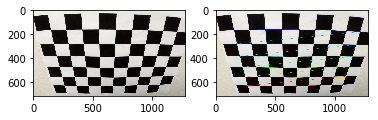

In [3]:
img=mpimg.imread('./camera_cal/calibration2.jpg')
plt.subplot(1,2,1)
plt.imshow(img)
objpoints=[]
imgpoints=[]

objp = np.zeros((9*6,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    img=cv2.drawChessboardCorners(img,(9,6),corners,ret)
    plt.subplot(1,2,2)
    plt.imshow(img)

## Step 2: Using a number of images to get the undistorted matrix 

In [4]:
%matplotlib qt5
import glob

images=glob.glob('./camera_cal/calibration*.jpg')
objpoints=[]
imgpoints=[]
objp = np.zeros((9*6,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
for fname in images:
    img = mpimg.imread(fname)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
   

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)




## Step 3: Apply the matrix on the chessboard image

(1281, 721)


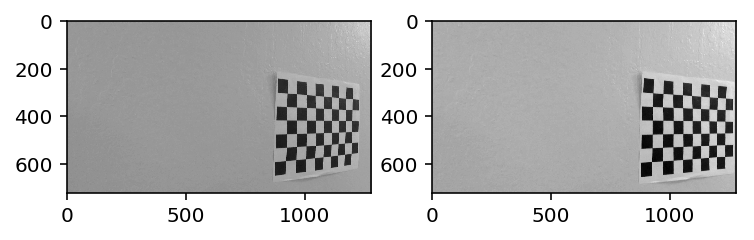

In [5]:
img=mpimg.imread('./camera_cal/calibration15.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print (img.shape[::-1])
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(dst,cmap='gray')

## Step 4: Apply the matrix on the road image 

####  cv2.undistort(image, mtx, dist, None, mtx)

(3, 1280, 720)


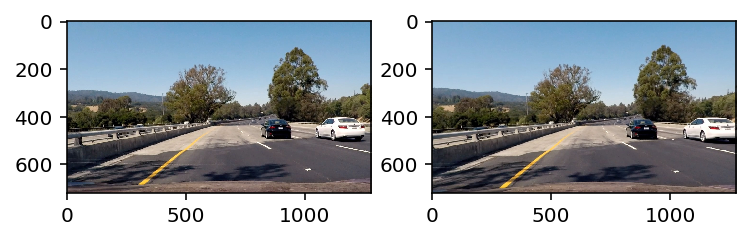

In [6]:
img=mpimg.imread('./test_images/test4.jpg')
#img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print (img.shape[::-1])
plt.subplot(1,2,1)
plt.imshow(img)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(dst)

## Step 5: Perspective Transform

#### Img_unwarp, M, Minv = unwarp(image, src, dst)

Text(0.5,1,'Unwarped Image')

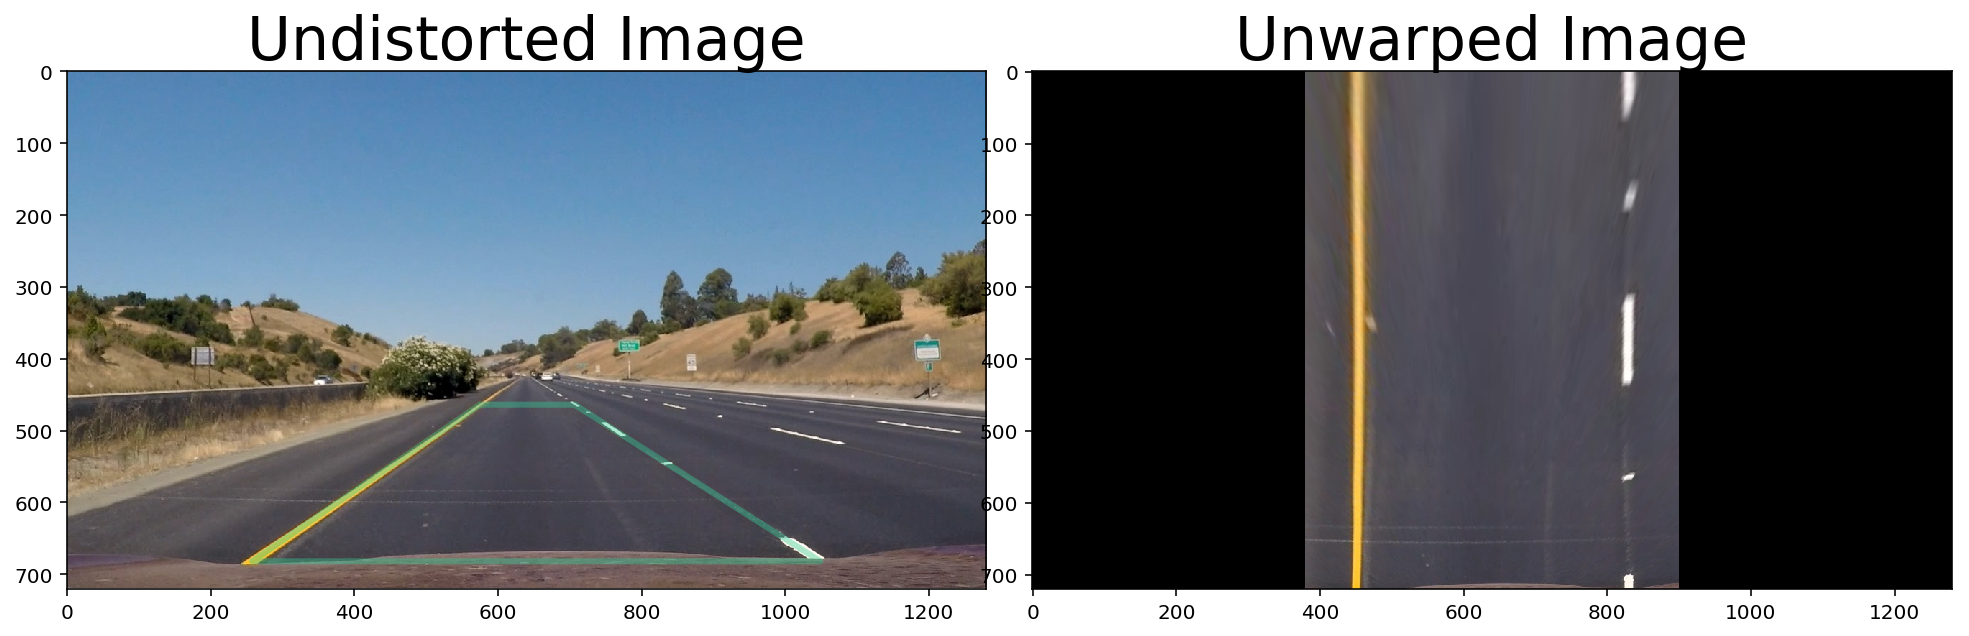

In [7]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    # limit the region
    warped[:,:380,:]=0
    warped[:,(w-380):,:]=0
    
    return warped, M, Minv

image=mpimg.imread('./test_images/straight_lines1.jpg')
h,w = image.shape[:2]

src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

Img_unwarp, M, Minv = unwarp(image, src, dst)
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(image)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(Img_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

## Step 6 : Filter the whole image with color

#### Color_select(img)

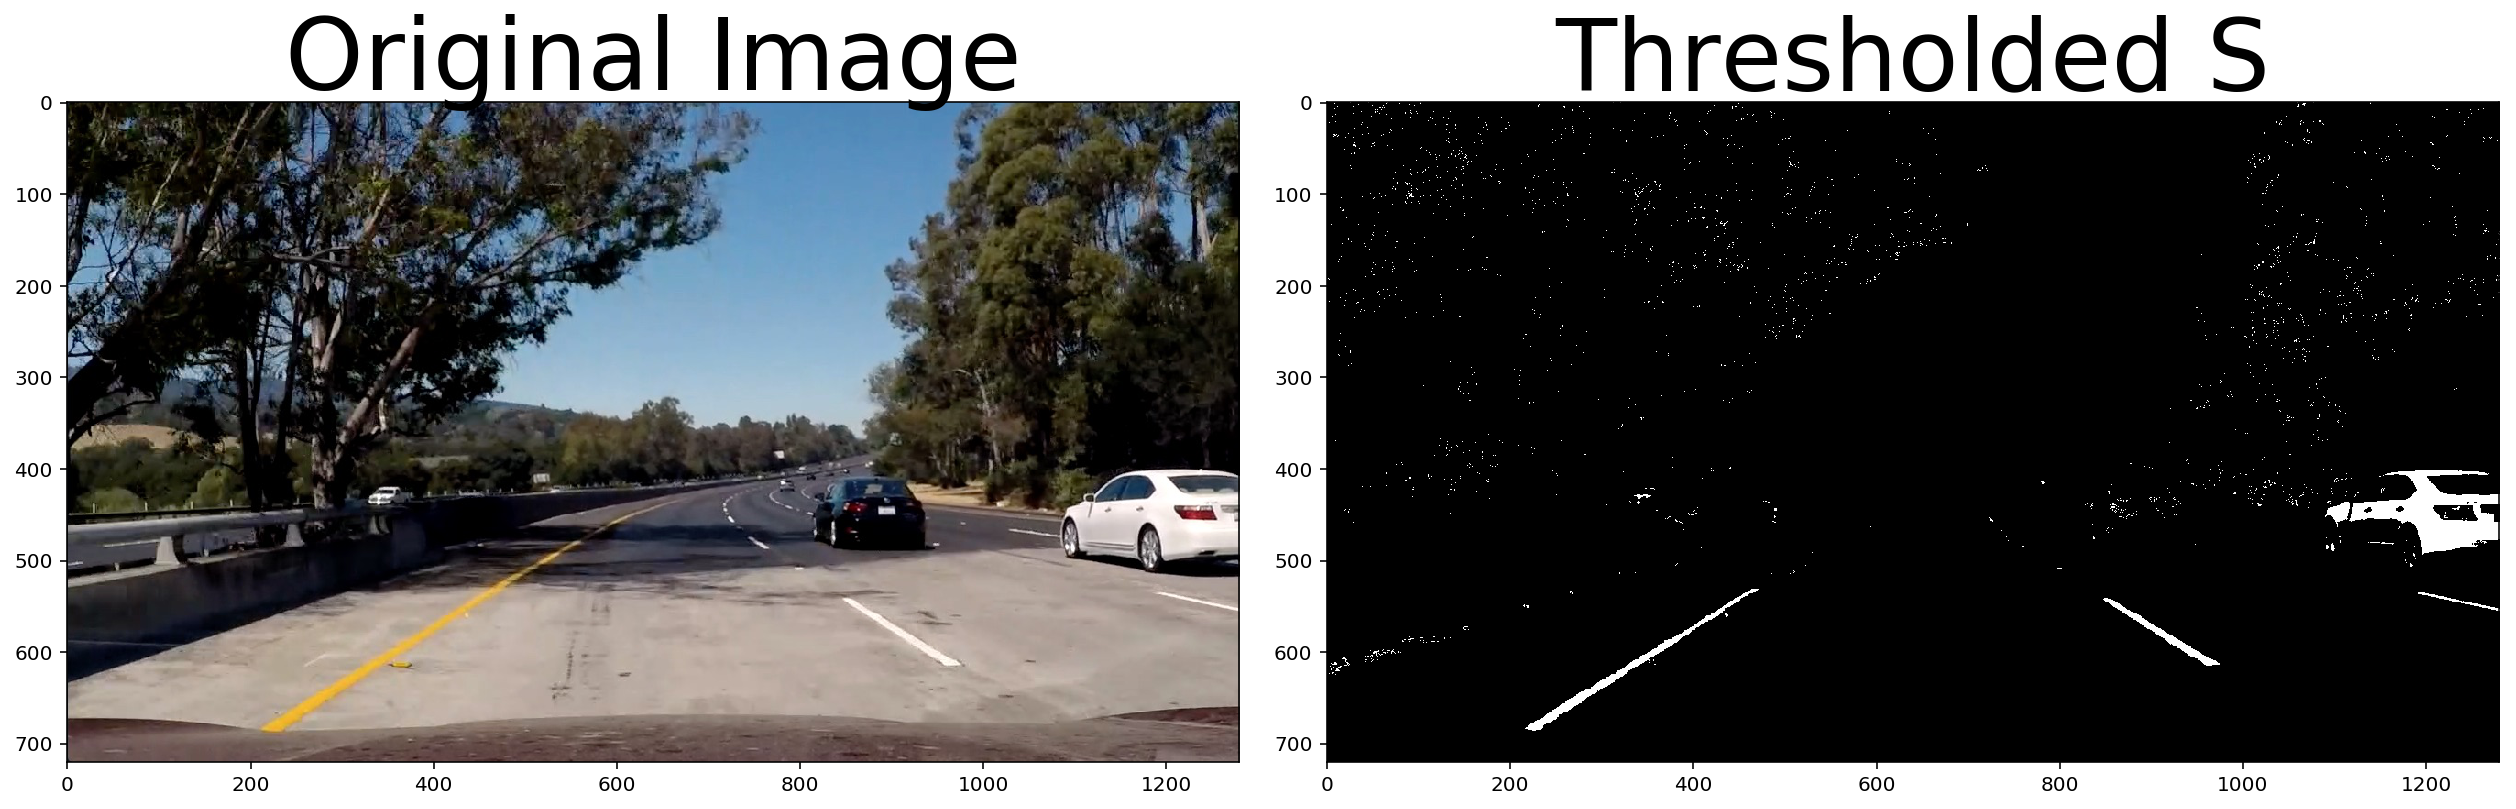

In [8]:
img=mpimg.imread('./test_images/test5.jpg')

def hls_select(img, thresh=(220, 245)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
     # placeholder line
    return binary

def RGB_select(img, thresh=(225, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
     # placeholder line
    return binary

def Color_select(img):
    
    A=hls_select(img)
    B=RGB_select(img)
    binary = np.zeros_like(A)
    binary[(A == 1) | (B == 1)] = 1
    return binary



hls_binary = Color_select(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 7: Filter the image with gradient

#### Combine_Grad(image)

In [9]:
def abs_sobel_thresh_x(img, orient='x', sobel_kernel=3, thresh=(30, 255)):
    binary_output = np.copy(img)
    if len(np.shape(binary_output))==3:
        gray = cv2.cvtColor(binary_output, cv2.COLOR_RGB2GRAY)
    else:
        gray=binary_output
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #scaled_sobel = cv2.GaussianBlur(scaled_sobel,(sobel_kernel,sobel_kernel),0)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min(thresh)) & (scaled_sobel <= max(thresh))] = 1
    return sxbinary


def abs_sobel_thresh_y(img, orient='y', sobel_kernel=3, thresh=(10, 255)):
    binary_output = np.copy(img)
    if len(np.shape(binary_output))==3:
        gray = cv2.cvtColor(binary_output, cv2.COLOR_RGB2GRAY)
    else:
        gray=binary_output
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    scaled_sobel = cv2.GaussianBlur(scaled_sobel,(sobel_kernel,sobel_kernel),0)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min(thresh)) & (scaled_sobel <= max(thresh))] = 1
    return sxbinary



def sobel_thresh(img, sobel_kernel=7, thresh=(30, 255)):
    # Calculate directional gradient
    # Apply threshold
    binary_output = np.copy(img)
    if len(np.shape(binary_output))==3:
        gray = cv2.cvtColor(binary_output, cv2.COLOR_RGB2GRAY)
    else:
        gray=binary_output
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel) 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_xy=np.sqrt(np.multiply(abs_sobelx,abs_sobelx)+np.multiply(abs_sobely,abs_sobely))
    scaled_sobel = np.uint8(255*sobel_xy/np.max(sobel_xy))
    scaled_sobel = cv2.GaussianBlur(scaled_sobel,(sobel_kernel,sobel_kernel),0)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min(thresh)) & (scaled_sobel <= max(thresh))] = 1
    return sxbinary



def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Calculate gradient direction
    # Apply threshold
    binary_output = np.copy(img)
    
    if len(np.shape(binary_output))==3:
        gray = cv2.cvtColor(binary_output, cv2.COLOR_RGB2GRAY)
    else:
        gray=binary_output
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobelx = cv2.GaussianBlur(abs_sobelx,(sobel_kernel,sobel_kernel),0)
    abs_sobely = np.absolute(sobely)
    abs_sobely = cv2.GaussianBlur(abs_sobely,(sobel_kernel,sobel_kernel),0)
    angle=np.arctan2(abs_sobely,abs_sobelx)
    sxbinary = np.zeros_like(angle)
    sxbinary[(angle >= min(thresh)) & (angle <= max(thresh))] = 1
    return sxbinary

def Combine_Grad(image):
    A=abs_sobel_thresh_x(image)
    B=abs_sobel_thresh_y(image)
    C=sobel_thresh(image)
    D=dir_threshold(image)
    sxbinary = np.zeros_like(D)
    sxbinary[(A == 1) & (B==1)& (C==1)& (D==1)] = 1
    return sxbinary
    

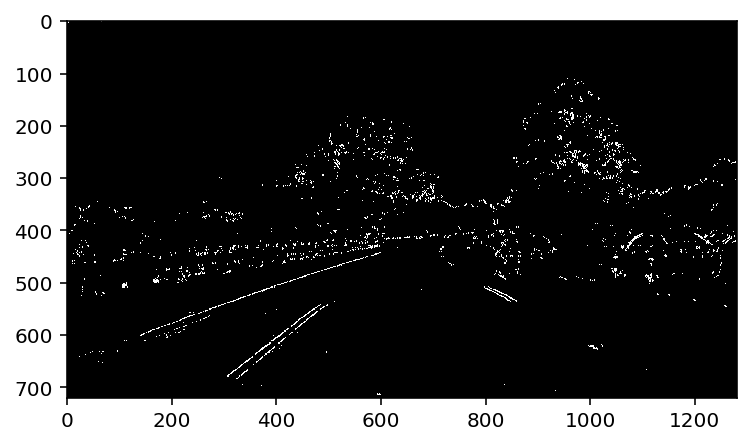

In [10]:
image=mpimg.imread('./test_images/test4.jpg')
plt.imshow(Combine_Grad(image),cmap='gray')

## Step 8 : Put all those filters together

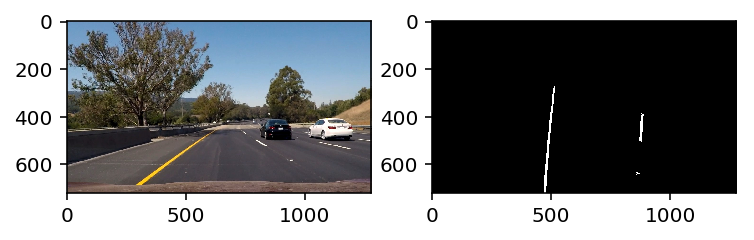

In [11]:
img=mpimg.imread('./test_images/test6.jpg')
image= cv2.undistort(img, mtx, dist, None, mtx)

image, M, Minv = unwarp(image, src, dst)

def Final_image(image):
    A=Color_select(image)
    B=Combine_Grad(image)
    binary = np.zeros_like(A)
    binary[(A == 1) | (B == 1)] = 1
    return binary

image=Final_image(image)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(image,cmap='gray')

## Step 9: Sliding window

(720, 0)

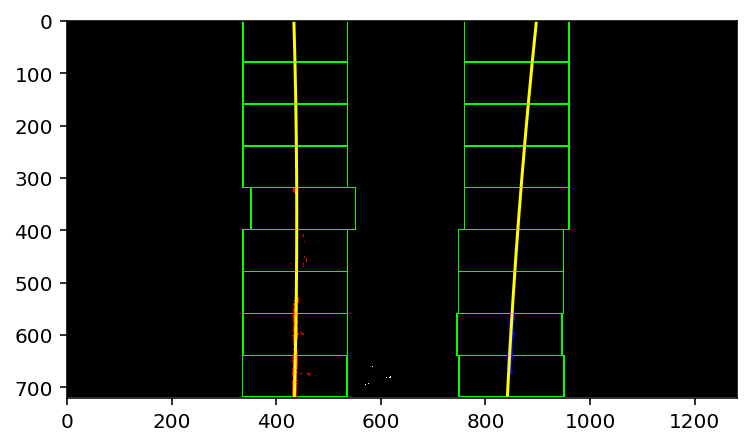

In [12]:
img=mpimg.imread('./test_images/test5.jpg')
image= cv2.undistort(img, mtx, dist, None, mtx)
image, M, Minv = unwarp(image, src, dst)
image=Final_image(image)


out_img = np.dstack((image, image, image))*255

histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(image.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = image.shape[0] - (window+1)*window_height
    win_y_high = image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

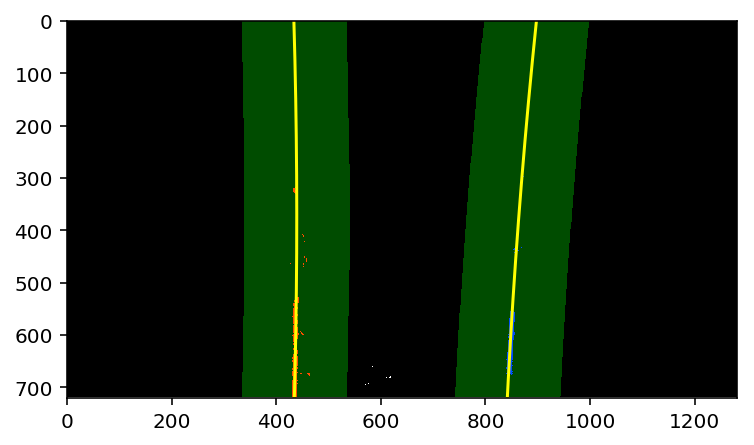

In [13]:
out_img = np.dstack((image, image, image))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Step 10: Add the region back on the original image

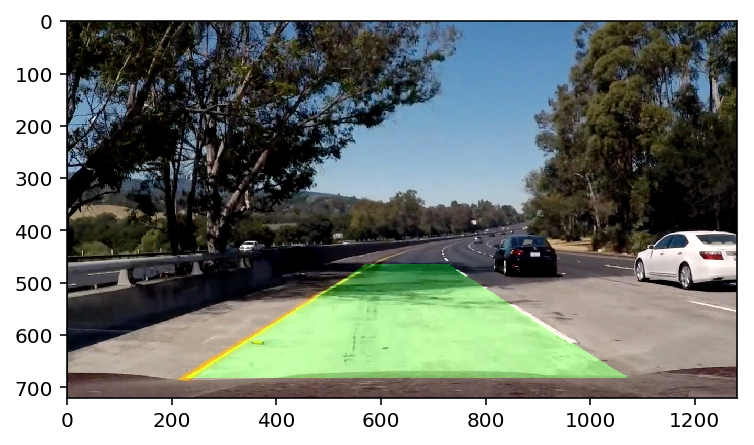

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Step 11: Process one image

In [15]:
def AdvancedLaneFinding(img):
    image= cv2.undistort(img, mtx, dist, None, mtx)
    image, M, Minv = unwarp(image, src, dst)
    image=Final_image(image)
    out_img = np.dstack((image, image, image))*255
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if len(leftx)==0 or len(lefty)==0:
        leftx=rightx
        lefty=righty
    if len(rightx)==0 or len(righty)==0:
        rightx=leftx
        righty=lefty
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(out_img, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result


IndexError: too many indices for array

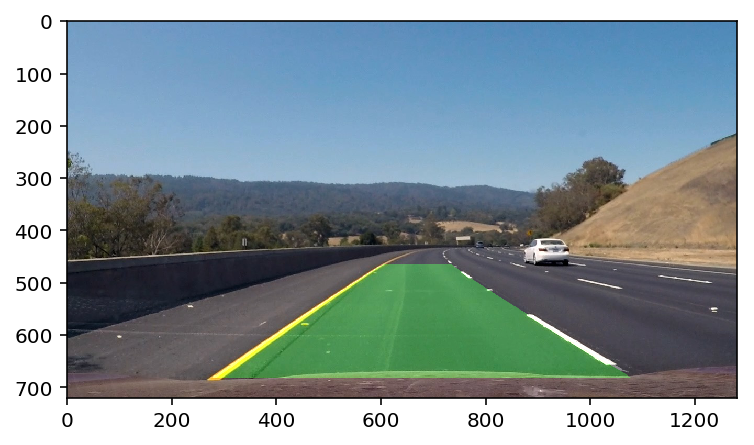

In [16]:
img=mpimg.imread('./test_images/test3.jpg')
result=AdvancedLaneFinding(img)
plt.imshow(result)


import os
Picture_array=os.listdir("test_images/")
image_out=[]
for i in range(len(Picture_array)):
    image_out.append(AdvancedLaneFinding(i))

for i in range(len(Picture_array)):
    mpimg.imsave("output_images/"+Picture_array[i],image_out[i])

## Step 12: Solve video

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [27]:
#os.mkdir('result_videos_output')
white_output = './Result_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(AdvancedLaneFinding) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./Result_project_video.mp4
[MoviePy] Writing video ./Result_project_video.mp4


100%|█████████▉| 1260/1261 [05:02<00:00,  4.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Result_project_video.mp4 

CPU times: user 4min 39s, sys: 53.5 s, total: 5min 32s
Wall time: 5min 3s
